api로 단지코드 가져오기


In [1]:
### api로 단지코드 가져오기
import requests
import xmltodict
import json
from datetime import datetime
from dateutil.relativedelta import *


# sido_code: {'대구':'27','인천':'28','광주':'29','대전':'30','울산':'31','경기':'41','강원':'42','충북':'43','충남':'44','전북':'45','전남':'46','경북':'47','경남':'48','제주':'50'}
# input_danji_name
def apt_danji(sido,name):
    service_dkey = 'X3P5kZCUe75RwQN0GH80YdI51JbHHwlOWkQLJiRyFIbgn/RiaVJmjOX/yFbt50x4rAhtPGt4Jlya+rIJlUefaA=='
    url = 'http://apis.data.go.kr/1613000/AptListService2/getSidoAptList'
    param = {'serviceKey':service_dkey, 'sidoCode':sido, 'pageNo':1, 'numOfRows':'1'}
    r = requests.get(url,params=param)
    
    xmlData = r.content.decode('utf-8')
    parseData = xmltodict.parse(xmlData)
    jData = json.loads(json.dumps(parseData))
    
    rows=jData['response']['body']['totalCount']
    
    pages = int(int(rows)/100)+1    
    row_cnt=1
    for i in range(1, pages+1):
        params={'serviceKey':service_dkey, 'sidoCode':sido, 'pageNo':i, 'numOfRows':'100'}
        
        response = requests.get(url, params=params)
        xml_data = response.content.decode('utf-8')
        parse_data = xmltodict.parse(xml_data)
        
        ord_data = parse_data['response']['body']['items']['item']
        
        try:
            jdata = json.loads(json.dumps(ord_data))
            input_danji_name=name
            
            for code_data in jdata:
                danji_code=code_data['kaptCode']
                danji_name=code_data['kaptName']
                row_cnt += 1
                if danji_name == input_danji_name:
                    # print(code_data)
                    return danji_code
                
        except Exception as e:
            print(f'Error: {e}\n')
            break

# 단지별 전기, 수도 총 사용량을 세대수로 나눠 평균 사용양 알아내기
### api로 단지별 세대수 불러오기
def danji_people(code):
    url = 'http://apis.data.go.kr/1613000/AptBasisInfoService1/getAphusBassInfo'
    params ={'serviceKey':'X3P5kZCUe75RwQN0GH80YdI51JbHHwlOWkQLJiRyFIbgn/RiaVJmjOX/yFbt50x4rAhtPGt4Jlya+rIJlUefaA==',
         'kaptCode' : code}
    response = requests.get(url, params=params)
    xml_data = response.content.decode('utf-8')
    parse_data = xmltodict.parse(xml_data)
    ord_data = parse_data['response']['body']
    jData = json.loads(json.dumps(ord_data))
    jData = jData['item']
    return jData['kaptdaCnt']

### api로 단지별 전기 사용량 불러오기
def danji_elect(code,date):
    url = 'http://apis.data.go.kr/1611000/AptIndvdlzManageCostService/getHsmpElectricityCostInfo'
    params ={'serviceKey':'X3P5kZCUe75RwQN0GH80YdI51JbHHwlOWkQLJiRyFIbgn/RiaVJmjOX/yFbt50x4rAhtPGt4Jlya+rIJlUefaA==',
         'kaptCode' : code, 'searchDate' : str(date) }
    response = requests.get(url, params=params)
    xml_data = response.content.decode('utf-8')
    parse_data = xmltodict.parse(xml_data)
    ord_data = parse_data['response']['body']
    jData = json.loads(json.dumps(ord_data))
    jData = jData['item']
    return jData['electP']

### api로 단지별 수도 사용량 불러오기
def danji_water(code,date):
    url = 'http://apis.data.go.kr/1611000/AptIndvdlzManageCostService/getHsmpWaterCostInfo'
    params ={'serviceKey':'X3P5kZCUe75RwQN0GH80YdI51JbHHwlOWkQLJiRyFIbgn/RiaVJmjOX/yFbt50x4rAhtPGt4Jlya+rIJlUefaA==',
         'kaptCode' : code, 'searchDate' : str(date) }
    response = requests.get(url, params=params)
    xml_data = response.content.decode('utf-8')
    parse_data = xmltodict.parse(xml_data)
    ord_data = parse_data['response']['body']
    jData = json.loads(json.dumps(ord_data))
    jData = jData['item']
    return jData['waterCoolP']

sido_code=29    
apt_danji(sido_code,"삼각그린타운")

'A50079001'

# Eggo AI의 충고
### api 사용해 단지 평균 전기료, 수도료 가져오기

In [2]:
danji_elect_price_dict={}
danji_water_price_dict={}
danji_elect_price_list=[]
danji_water_price_list=[]

months_list=[]
present_date = datetime.today().strftime("%Y%m")

# 단지 평균 전기료 조회 (13개월)
for i in range(3,16): # 현재 달로부터 3개월 전부터 조회가능
    ago_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-(18-i))).strftime("%Y%m")
    electP = danji_elect(apt_danji(sido_code,"삼각그린타운"),ago_month) # 우리단지 총액
    danji_elect_price = round(int(electP)/int(danji_people(apt_danji(sido_code,"삼각그린타운"))))
    danji_elect_price_dict[ago_month]= danji_elect_price
    months_list.append(ago_month)
    danji_elect_price_list.append(danji_elect_price)


# 단지 평균 수도료 조회 (13개월)
for i in range(3,16): # 현재 달로부터 3개월 전부터 조회가능
    ago_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-(18-i))).strftime("%Y%m")
    waterP = danji_water(apt_danji(sido_code,"삼각그린타운"),ago_month) # 우리단지 총액
    danji_water_price = round(int(waterP)/int(danji_people(apt_danji(sido_code,"삼각그린타운"))))
    danji_water_price_dict[ago_month]= danji_water_price
    danji_water_price_list.append(danji_water_price)

# print("단지 평균 전기료 조회")
# print(danji_elect_price_dict,"\n")
# print("단지 평균 수도료 조회")
# print(danji_water_price_dict)


In [3]:
# ### k-apt api를 이용한 관리비 예측 구현(13개월 데이터로 예측)
# Radial Basis Function(RBF)커널을 사용한 SVM(서포트 백터 머신)으로 예측 알고리즘 구현

# from sklearn.svm import SVR
# import pandas as pd
# from pandas_datareader import data as pdr
# import matplotlib.pyplot as plt

# months=[]
# j=1

# for j in range(len(danji_elect_price_list)):
#     months.append([int(j+1)])
#     j=j+1

# # C가 낮을수록 일반적인 결정, 높을수록 이상치의 존재 가능성 작게 봐서 세심한 결정(너무 낮거나 높으면 과소, 과대적합될 수 있음)
# # gamma는 하나의 데이터 샘플이 영향력을 행사하는 거리 결정, 값이 클수록 작은 표준편차 가짐
# rbf_svr_e = SVR(kernel='rbf', C=5000, gamma=0.5)
# rbf_svr_w = SVR(kernel='rbf', C=5000, gamma=0.5)

# rbf_svr_e.fit(months, danji_elect_price_list)
# rbf_svr_w.fit(months, danji_water_price_list)

# nextMonth = [[len(months)+1]]

# n_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-1)).strftime("%Y%m")
# print('RBF',n_month,"월 예측 전기료:",rbf_svr_e.predict(nextMonth))
# print('RBF',n_month,"월 예측 수도료:",rbf_svr_w.predict(nextMonth))


# plt.figure(figsize=(10,5))
# plt.plot(months_list, danji_elect_price_list ,label='Actual elect')
# plt.plot(months_list, rbf_svr_e.predict(months),label='RBF')
# plt.plot(months_list, danji_water_price_list, label='Actual water')
# plt.plot(months_list, rbf_svr_w.predict(months), label='RBF')



# plt.legend()
# plt.show()

# ### 사용자 데이터에 대입 해야함

# 아파트 평균 수도료+전기료와 사용자의 수도료+전기료 비교 그래프 (eggo AI의 충고)

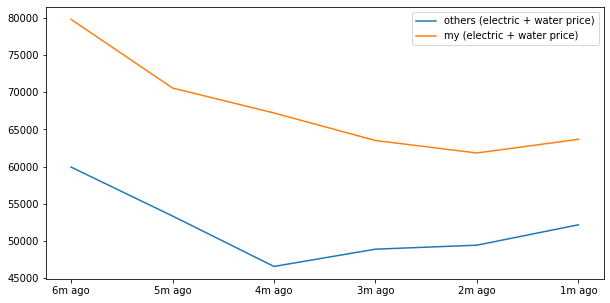

우리 아파트 202203 예상 금액(전기+수도): [51314.85826234]
아파트 평균 금액 변화율에 따른 우리 집 202203 예상 금액(전기+수도): [62646.54093356]


In [5]:

from sklearn.svm import SVR
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
 
#------------ 합칠 때 지우기
x6=['6m ago','5m ago','4m ago','3m ago','2m ago','1m ago']
test_elec_price=[35000,38010,28150,28800,27160,39330,37470,51389,42140,34740,36410,33390,40610] # 41280
test_wat_price=[24990,28430,29780,24390,25740,25740,29780,28430,28430,32470,27090,28430,23050] # 25740
#------------
user_ew=[]
danji_ew=[]

for i in range(len(test_elec_price)):
    user_ew.append(test_elec_price[i]+test_wat_price[i])
for i in range(len(danji_elect_price_list)):
    danji_ew.append(danji_elect_price_list[i]+danji_water_price_list[i])

plt.figure(figsize=(10,5)) 
plt.plot(x6,danji_ew[-6:],label='others (electric + water price)')
plt.plot(x6,user_ew[-6:], label='my (electric + water price)')
plt.legend()
plt.show()

#------------------

### 13달 데이터로 예측
# Radial Basis Function(RBF)커널을 사용한 SVM(서포트 백터 머신)으로 예측 알고리즘 구현

months=[]
j=1

for j in range(len(danji_elect_price_list)):
    months.append([int(j+1)])
    j=j+1

# C가 낮을수록 일반적인 결정, 높을수록 이상치의 존재 가능성 작게 봐서 세심한 결정(너무 낮거나 높으면 과소, 과대적합될 수 있음)
# gamma는 하나의 데이터 샘플이 영향력을 행사하는 거리 결정, 값이 클수록 작은 표준편차 가짐
rbf_svr_e = SVR(kernel='rbf', C=5000, gamma=0.5)
rbf_svr_w = SVR(kernel='rbf', C=5000, gamma=0.5)
rbf_svr_e1 = SVR(kernel='rbf', C=8000, gamma=0.5) ##
rbf_svr_w1 = SVR(kernel='rbf', C=7000, gamma=0.5) ##

rbf_svr_e.fit(months, danji_elect_price_list)
rbf_svr_w.fit(months, danji_water_price_list)
rbf_svr_e1.fit(months,test_elec_price) ##
rbf_svr_w1.fit(months,test_wat_price) ##

nextMonth = [[len(months)+1]]
predict_danji_ew = rbf_svr_e.predict(nextMonth) + rbf_svr_w.predict(nextMonth)
predict_user_ew = rbf_svr_e1.predict(nextMonth)+rbf_svr_w1.predict(nextMonth)
n_month = (datetime(datetime.today().year,datetime.today().month,1)+relativedelta(months=-1)).strftime("%Y%m")
print("우리 아파트",n_month,"예상 금액(전기+수도):",predict_danji_ew)
change_rate=predict_danji_ew/danji_ew[-1]
print("아파트 평균 금액 변화율에 따른 우리 집",n_month,"예상 금액(전기+수도):",user_ew[-1]*change_rate)
